In [1]:
import pickle
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import FastICA
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import nibabel as nib
import ants
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
import cv2
import bigbadbrain as bbb
import scipy
from scipy.interpolate import interp1d
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm
import matplotlib.colors as mcolors
import matplotlib
import tqdm
import brainsss
from scipy.spatial.transform import Rotation as R

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


# Creat L vs R voxel plots for all SVs

In [2]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"

In [3]:
### Load Supercluster Signals ###
file = os.path.join(cluster_dir, "20221202_SC_signals.npy")
supercluster_signals = np.load(file)
supercluster_signals.shape

(501, 30456)

In [4]:
### ADDING THIS 20230421
#supercluster_signals /= np.std(supercluster_signals,axis=1)[:,np.newaxis]

In [5]:
file = os.path.join(cluster_dir,"20221122_behavior_fwd.npy")
beh_fwd = np.load(file)
print(beh_fwd.shape)

file = os.path.join(cluster_dir,"20221122_behavior_turn.npy")
beh_turn = np.load(file)
print(beh_turn.shape)

(30456,)
(30456,)


In [6]:
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"

behaviors = ['dRotLabY', 'dRotLabZ', 'dRotLabX']; shorts = ['Y', 'Z', 'X']

fictrac = {'Y': [], 'Z': [], 'X': []}

for fly in fly_names:
    fly_dir = os.path.join(dataset_path, fly)
    fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'func_0', 'fictrac'))
    for behavior, short in zip(behaviors, shorts):
        fictrac[short].append(fictrac_raw[behavior])

for short in shorts:    
    fictrac[short] = np.asarray(fictrac[short])


~~ load_fictrac ~~
load_fictrac done. Duration: 3.60 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 3.48 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 3.58 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 3.50 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 3.69 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 3.58 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 3.59 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 3.49 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 3.55 sec


In [7]:
fictrac_data = np.reshape(np.stack((fictrac['X'], fictrac['Y'], fictrac['Z'])),(3,-1))
r = R.from_euler('xyz', [-6.46013698, -12.92761252,   3.29629772], degrees=True).as_dcm()
fictrac_data_r = np.matmul(fictrac_data.T,r).T

fictrac_data_rotated = {'Y': fictrac_data_r[1,:],
                        'Z': fictrac_data_r[2,:]}

In [8]:
# Create camera timepoints
fps=50
camera_rate = 1/fps * 1000 # camera frame rate in ms
expt_len = 1000*30*60
x_original = np.arange(0,expt_len,camera_rate)

# new timepoints
width = 30000 
step = 20 #in ms
time_shifts = list(range(-width,width,step))
xs = np.asarray(time_shifts)/1000

# neural timepoints
file = os.path.join(dataset_path, 'fly_087', 'func_0', 'imaging')
neural_timestamps = brainsss.load_timestamps(file)

Trying to load timestamp data from hdf5 file.
Success.


In [9]:
step = 90000
sliding_fictrac = {}
for beh in ['Y', 'Z']:
    print(beh)

    all_behavior_shifts = []
    for k,fly in enumerate(fly_names):
        
        # Smooth fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(fictrac_data_rotated[beh][step*k:step*(k+1)],25,3)

        # Create interp object with camera timepoints
        interp_obj = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        
        behavior_shifts = []
        for shift in time_shifts:
            fictrac_interp = interp_obj(neural_timestamps[:,20]+shift)#flies[fly].timestamps[:,z]+shift)
            fictrac_interp = np.nan_to_num(fictrac_interp)
            behavior_shifts.append(fictrac_interp)
        all_behavior_shifts.append(np.asarray(behavior_shifts))
    all_behavior_shifts = np.asarray(all_behavior_shifts)
    sliding_fictrac[beh] = np.reshape(np.moveaxis(all_behavior_shifts,0,1),(-1,30456))

Y
Z


In [10]:
### from 20230411 - map spread of asymmetry around time zero (paper figure 3)
OK_clusters = [  1,   2,   4,   5,   6,   7,   9,  10,  11,  12,  14,  16,  17,
        18,  19,  21,  22,  25,  26,  27,  30,  32,  34,  38,  39,  40,
        43,  47,  51,  52,  54,  57,  60,  62,  63,  65,  66,  69,  71,
        72,  73,  76,  77,  78,  80,  82,  84,  85,  86,  88,  89,  90,
        91,  93,  94,  95, 101, 102, 103, 104, 106, 109, 110, 111, 112,
       113, 115, 116, 117, 119, 121, 122, 123, 126, 129, 134, 135, 138,
       141, 142, 143, 144, 146, 147, 149, 150, 151, 152, 154, 156, 157,
       158, 159, 162, 163, 165, 166, 172, 173, 175, 176, 178, 179, 180,
       182, 185, 186, 187, 188, 189, 195, 198, 199, 200, 201, 203, 204,
       206, 212, 213, 215, 216, 219, 223, 224, 225, 226, 227, 228, 229,
       232, 233, 237, 239, 240, 245, 246, 247, 248, 249]

In [11]:
### MAKE R/G MAP ###
cmap1 = mcolors.LinearSegmentedColormap.from_list('mycmap', ['red', 'k'])
cmap2 = mcolors.LinearSegmentedColormap.from_list('mycmap', ['k', '#00FF00'])

colors1 = cmap1(np.linspace(0, .7, 128))
colors2 = cmap2(np.linspace(.1, 1, 128))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
RG_map = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

### MAKE BLUE MAKE ###
blue_cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', ['w', 'blue'])

In [18]:
shift = 1500
behavior = sliding_fictrac['Z'][shift,:].copy()* 180 / np.pi * fps
sphere_radius = 4.5e-3 # in m
#behavior = sliding_fictrac['Y'][shift,:].copy() * sphere_radius * fps * 1000


hists = []
samples_num = []
for cluster in tqdm.tqdm(range(250)):
    x_data = supercluster_signals[cluster,:] / np.std(supercluster_signals[cluster,:])
    y_data = supercluster_signals[cluster+250,:] / np.std(supercluster_signals[cluster+250,:])

    start=-.6
    stop=.6
    start=-4
    stop=4
    num_bins=30#40
    min_num_samples=10

    # Define bins
    bins = np.linspace(start,stop,num_bins)

    # Assign neural values to bin numbers
    idx_x, idx_y = np.digitize(x_data,bins), np.digitize(y_data,bins)

    binned_signal = []
    sample_count = []
    for i in range(num_bins):
        mask_x = (idx_x == i)
        for j in range(num_bins):
            mask_y = (idx_y == j)
            mask = mask_x & mask_y

            binned_signal.append(np.mean(behavior[mask]))
    #         try:
    #             binned_signal.append(np.percentile(behavior[mask],90))
    #         except IndexError:
    #             binned_signal.append(np.nan)
            sample_count.append(np.count_nonzero(~np.isnan(behavior[mask])))

    binned_signal = np.reshape(binned_signal,(num_bins, num_bins))
    sample_count = np.reshape(sample_count,(num_bins, num_bins))
    hists.append(binned_signal)
    samples_num.append(sample_count)

100%|██████████| 250/250 [00:07<00:00, 31.98it/s]


In [17]:
fwd_hists = hists.copy()
fwd_samples_num = samples_num.copy()

In [19]:
turn_hists = hists.copy()
turn_samples_num = samples_num.copy()

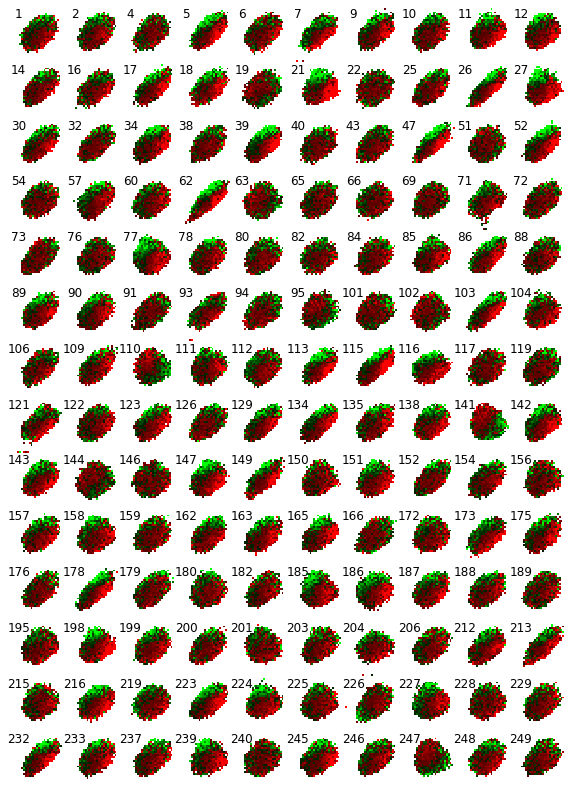

In [20]:
fig = plt.figure(figsize=(10,25))
grid = ImageGrid(fig, 111, nrows_ncols=(14, 10), axes_pad=0)

#for i,ax in enumerate(grid):
for i,cluster in enumerate(OK_clusters):
    turn_hists[cluster][np.where(turn_samples_num[cluster]<10)] = np.nan
    grid[i].imshow(turn_hists[cluster],cmap=RG_map,vmin=-40,vmax=40) #TURNING
    #grid[i].imshow(turn_hists[cluster],cmap=blue_cmap,vmin=0,vmax=2) #FWD
    grid[i].set_axis_off()
    grid[i].set_title(cluster,x=.15,y=.7)
    grid[i].invert_yaxis()
    
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

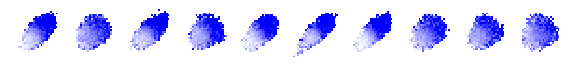

In [30]:
fig = plt.figure(figsize=(10,25))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 10), axes_pad=0)

selected_rois = [5,12,17,21,39,62,115,147,198,239]

#for i,ax in enumerate(grid):
for i,cluster in enumerate(selected_rois):
    #turn_hists[cluster][np.where(turn_samples_num[cluster]<10)] = np.nan
    #grid[i].imshow(turn_hists[cluster],cmap=RG_map,vmin=-40,vmax=40) #TURNING
    
    fwd_hists[cluster][np.where(fwd_samples_num[cluster]<10)] = np.nan
    grid[i].imshow(fwd_hists[cluster],cmap=blue_cmap,vmin=0,vmax=2) #FWD
    grid[i].set_axis_off()
    #grid[i].set_title(cluster,x=.55,y=1)
    grid[i].invert_yaxis()
    
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [111]:
shift = 1500
behavior = sliding_fictrac['Z'][shift,:].copy()* 180 / np.pi * fps
sphere_radius = 4.5e-3 # in m
#behavior = sliding_fictrac['Y'][shift,:].copy() * sphere_radius * fps * 1000

supercluster_signals_std = supercluster_signals/np.std(supercluster_signals,axis=1)[:,np.newaxis]

x_data = np.mean(supercluster_signals_std[:250,:],axis=0)
y_data = np.mean(supercluster_signals_std[250:,:],axis=0)

start=-4
stop=4
num_bins=30
min_num_samples=10

# Define bins
bins = np.linspace(start,stop,num_bins)

# Assign neural values to bin numbers
idx_x, idx_y = np.digitize(x_data,bins), np.digitize(y_data,bins)

binned_signal = []
sample_count = []
for i in range(num_bins):
    mask_x = (idx_x == i)
    for j in range(num_bins):
        mask_y = (idx_y == j)
        mask = mask_x & mask_y

        binned_signal.append(np.mean(behavior[mask]))
#         try:
#             binned_signal.append(np.percentile(behavior[mask],90))
#         except IndexError:
#             binned_signal.append(np.nan)
        sample_count.append(np.count_nonzero(~np.isnan(behavior[mask])))

binned_signal = np.reshape(binned_signal,(num_bins, num_bins))
sample_count = np.reshape(sample_count,(num_bins, num_bins))

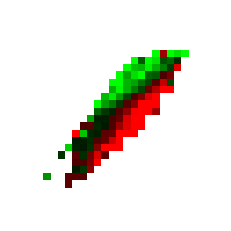

In [113]:
#binned_signal[np.where(sample_count<10)] = np.nan
plt.imshow(binned_signal,cmap=RG_map,vmin=-100,vmax=100) #TURNING
#plt.imshow(binned_signal,cmap=blue_cmap,vmin=0,vmax=4) #FWD
ax = plt.gca()
ax.set_axis_off()
ax.invert_yaxis()

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [51]:
shift = 1500
behavior = sliding_fictrac['Z'][shift,:].copy()* 180 / np.pi * fps
sphere_radius = 4.5e-3 # in m
behavior = sliding_fictrac['Y'][shift,:].copy() * sphere_radius * fps * 1000


cluster = 77
x_data = supercluster_signals[cluster,:] / np.std(supercluster_signals[cluster,:])
y_data = supercluster_signals[cluster+250,:] / np.std(supercluster_signals[cluster+250,:])

start=-.6
stop=.6
start=-4
stop=4
num_bins=30#40
min_num_samples=10

# Define bins
bins = np.linspace(start,stop,num_bins)

# Assign neural values to bin numbers
idx_x, idx_y = np.digitize(x_data,bins), np.digitize(y_data,bins)

binned_signal = []
sample_count = []
for i in range(num_bins):
    mask_x = (idx_x == i)
    for j in range(num_bins):
        mask_y = (idx_y == j)
        mask = mask_x & mask_y

        #binned_signal.append(np.percentile(behavior[mask],50))
        try:
            binned_signal.append(np.percentile(behavior[mask],90))
        except IndexError:
            binned_signal.append(np.nan)
        sample_count.append(np.count_nonzero(~np.isnan(behavior[mask])))

binned_signal = np.reshape(binned_signal,(num_bins, num_bins))
sample_count = np.reshape(sample_count,(num_bins, num_bins))

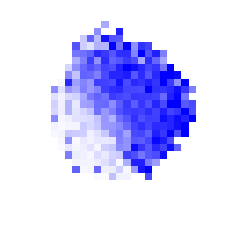

In [54]:
binned_signal[np.where(sample_count<10)] = np.nan
#plt.imshow(binned_signal,cmap=RG_map,vmin=-40,vmax=40) #TURNING
plt.imshow(binned_signal,cmap=blue_cmap,vmin=0,vmax=7) #FWD
ax = plt.gca()
ax.set_axis_off()
ax.invert_yaxis()

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)